In [ ]:
import glob
import os
import random

import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop

In [ ]:
DATA_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
INPUT_SIZE = 150

WEIGHT_URL = 'https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [ ]:
data_dir = keras.utils.get_file(
    os.path.basename(DATA_URL),
    DATA_URL,
    cache_dir='./',
    cache_subdir='',
    extract=True
)
train_dir = os.path.join(os.path.splitext(data_dir)[0], 'train')
val_dir = os.path.join(os.path.splitext(data_dir)[0], 'validation')

In [ ]:
train_data = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
train_generator = train_data.flow_from_directory(
    train_dir,
    target_size=(INPUT_SIZE, INPUT_SIZE),
    batch_size=32,
    class_mode='binary'
)

val_data = ImageDataGenerator(rescale=1.0/255)
val_generator = val_data.flow_from_directory(
    val_dir,
    target_size=(INPUT_SIZE, INPUT_SIZE),
    batch_size=32,
    class_mode='binary'
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
weight_path = keras.utils.get_file(
    os.path.basename(WEIGHT_URL),
    WEIGHT_URL,
    cache_dir='./',
    cache_subdir=''
)

In [ ]:
pre_trained_model = InceptionV3(
    input_shape=(INPUT_SIZE, INPUT_SIZE, 3), 
    include_top=False, 
    weights=None
)

pre_trained_model.load_weights(weight_path)

for layer in pre_trained_model.layers:
    layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [ ]:
x = keras.layers.Flatten()(last_output)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)                  
x = keras.layers.Dense  (1, activation='sigmoid')(x)           

model = keras.Model( pre_trained_model.input, x)

model.compile(
    optimizer=RMSprop(lr=0.0001), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    verbose=1
)

Epoch 1/20
63/63 [==============================] - 19s 308ms/step - loss: 0.3918 - accuracy: 0.8435 - val_loss: 0.0885 - val_accuracy: 0.9620
Epoch 2/20
63/63 [==============================] - 18s 291ms/step - loss: 0.2316 - accuracy: 0.9060 - val_loss: 0.1516 - val_accuracy: 0.9420
Epoch 3/20
63/63 [==============================] - 18s 293ms/step - loss: 0.1747 - accuracy: 0.9325 - val_loss: 0.1152 - val_accuracy: 0.9570
Epoch 4/20
63/63 [==============================] - 19s 296ms/step - loss: 0.1804 - accuracy: 0.9380 - val_loss: 0.1257 - val_accuracy: 0.9530
Epoch 5/20
63/63 [==============================] - 19s 297ms/step - loss: 0.1679 - accuracy: 0.9360 - val_loss: 0.1670 - val_accuracy: 0.9430
Epoch 6/20
63/63 [==============================] - 19s 294ms/step - loss: 0.1717 - accuracy: 0.9390 - val_loss: 0.0943 - val_accuracy: 0.9610
Epoch 7/20
63/63 [==============================] - 18s 293ms/step - loss: 0.1587 - accuracy: 0.9390 - val_loss: 0.1055 - val_accuracy: 0.9600

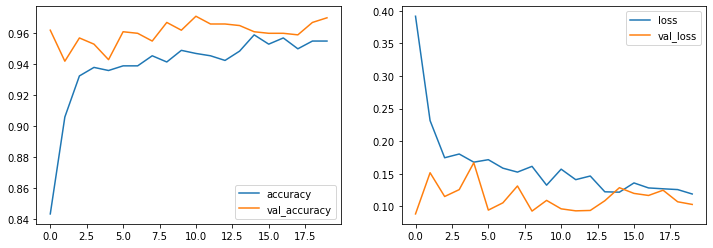

In [ ]:
epochs = range(len(history.history['accuracy']))
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='val_accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='loss')
plt.plot(epochs, history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()